In [1]:
!pip install gcm-filters
!pip install xrft==0.3.0

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:38169")
client

<Client: 'tcp://127.0.0.1:38169' processes=8 threads=64, memory=235.96 GiB>

In [23]:
client.restart()

<Client: 'tcp://127.0.0.1:42167' processes=7 threads=56, memory=220.41 GiB>

In [3]:
import numpy as np
import xarray as xr
import pandas as pd
from scipy.ndimage import rotate
from xgcm.grid import Grid
import gcm_filters
import xrft
import s3fs
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import intake
import os
import gcsfs

gcs = gcsfs.GCSFileSystem(requester_pays=True)

SCRATCH = os.environ['SCRATCH_BUCKET']
SCRATCH

'gcs://meom-ige-scratch/roxyboy'

In [5]:
from validate_catalog import all_params
params_dict, cat = all_params()
params_dict.keys()

dict_keys(['GIGATL', 'HYCOM50', 'eNATL60', 'FESOM', 'ORCA36'])

In [6]:
enatl01w = cat.eNATL60(region='1',datatype='interior_daily', season='fma'
                      ).to_dask().isel(deptht=slice(None,-1),depthv=slice(None,-1),depthu=slice(None,-1)
                                      ).chunk({'deptht':5,'depthw':5,
                                               'depthv':5,'depthu':5})
enatl01s = cat.eNATL60(region='1',datatype='interior_daily', season='aso'
                      ).to_dask().isel(deptht=slice(None,-1),depthv=slice(None,-1),depthu=slice(None,-1)
                                      ).chunk({'deptht':5,'depthw':5,
                                               'depthv':5,'depthu':5})
enatl01w

<xarray.Dataset>
Dimensions:       (deptht: 106, depthu: 106, depthv: 106, depthw: 107, time_counter: 89, x: 611, y: 763)
Coordinates: (12/18)
    depth         (y, x) float32 dask.array<chunksize=(73, 611), meta=np.ndarray>
  * deptht        (deptht) float32 0.4805 1.559 2.794 ... 951.6 968.4 985.3
  * depthu        (depthu) float32 0.4805 1.559 2.794 ... 951.6 968.4 985.3
  * depthv        (depthv) float32 0.4805 1.559 2.794 ... 951.6 968.4 985.3
  * depthw        (depthw) float32 0.0 1.0 2.157 3.471 ... 960.0 976.9 993.8
    e1f           (y, x) float64 dask.array<chunksize=(73, 611), meta=np.ndarray>
    ...            ...
    e2v           (y, x) float64 dask.array<chunksize=(73, 611), meta=np.ndarray>
    lat           (y, x) float32 dask.array<chunksize=(73, 611), meta=np.ndarray>
    lon           (y, x) float32 dask.array<chunksize=(73, 611), meta=np.ndarray>
    nav_lat       (y, x) float32 dask.array<chunksize=(73, 611), meta=np.ndarray>
    nav_lon       (y, x) float32 dask.array<chunksize=(73, 611), meta=np.ndarray>
  * time_counter  (time_counter) datetime64[ns] 2010-02-01 ... 2010-04-30
Dimensions without coordinates: x, y
Data variables: (12/13)
    e3t_0         (deptht, y, x) float64 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    e3u_0         (depthu, y, x) float64 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    e3v_0         (depthv, y, x) float64 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    e3w_0         (depthw, y, x) float64 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    fmask         (deptht, y, x) int8 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    tmask         (deptht, y, x) int8 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    ...            ...
    vmask         (depthv, y, x) int8 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    vomecrty      (time_counter, depthv, y, x) float32 dask.array<chunksize=(3, 5, 73, 611), meta=np.ndarray>
    vosaline      (time_counter, deptht, y, x) float32 dask.array<chunksize=(3, 5, 73, 611), meta=np.ndarray>
    votemper      (time_counter, deptht, y, x) float32 dask.array<chunksize=(3, 5, 73, 611), meta=np.ndarray>
    vovecrtz      (time_counter, depthw, y, x) float32 dask.array<chunksize=(3, 5, 73, 611), meta=np.ndarray>
    vozocrtx      (time_counter, depthu, y, x) float32 dask.array<chunksize=(3, 5, 73, 611), meta=np.ndarray>

In [7]:
filter_scale = 50000   # 50 km
# gcm_filters.required_grid_vars(gcm_filters.GridType.IRREGULAR_WITH_LAND)

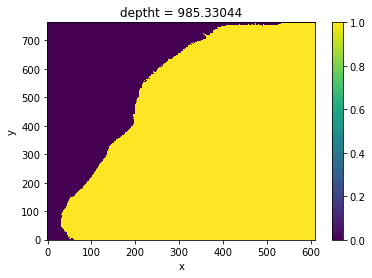

In [8]:
wet_mask = xr.DataArray(np.zeros_like(enatl01w.votemper.isel(time_counter=0)),
                        dims=['deptht','y','x'],
                        coords={'deptht':enatl01w.deptht,
                                'y':np.arange(len(enatl01w.y)),
                                'x':np.arange(len(enatl01w.x))}
           )
wet_mask[:,1:-1,1:-1] = enatl01w.tmask[:,1:-1,1:-1].data.astype(np.float64)

wet_mask.isel(deptht=-1).plot()

In [9]:
ww = xr.DataArray(.5*(enatl01w.vovecrtz.isel(depthw=slice(1,None)).fillna(0.).data 
                      + enatl01w.vovecrtz.isel(depthw=slice(None,-1)).fillna(0.).data
                     ),
                  dims=['time_counter','deptht','y','x'],
                  coords={'time_counter':enatl01w.time_counter.data, 'deptht':enatl01w.deptht,
                          'y':np.arange(len(enatl01w.y)),
                          'x':np.arange(len(enatl01w.x))}
                 ).chunk({'deptht':5})
ws = xr.DataArray(.5*(enatl01s.vovecrtz.isel(depthw=slice(1,None)).fillna(0.).data
                      + enatl01s.vovecrtz.isel(depthw=slice(None,-1)).fillna(0.).data
                     ),
                  dims=['time_counter','deptht','y','x'],
                  coords={'time_counter':enatl01s.time_counter.data, 'deptht':enatl01s.deptht,
                          'y':np.arange(len(enatl01s.y)),
                          'x':np.arange(len(enatl01s.x))}
                 ).chunk({'deptht':5})

In [10]:
grav = 9.81
w_path = f'{SCRATCH}/region01/eNATL60/'+f'sigma0_fma.zarr'
sig0w = xr.open_zarr(gcs.get_mapper(w_path)).sig0

s_path = f'{SCRATCH}/region01/eNATL60/'+f'sigma0_aso.zarr'
sig0s = xr.open_zarr(gcs.get_mapper(s_path)).sig0


bw = -xr.DataArray(sig0w.where(enatl01w.tmask!=0.).data,
                   dims=['time_counter','deptht','y','x'],
                   coords={'time_counter':enatl01w.time_counter.data, 'deptht':enatl01w.deptht,
                           'y':np.arange(len(enatl01w.y)),
                           'x':np.arange(len(enatl01w.x))}
                 ).chunk({'deptht':5}) * grav / 1e3
bs = -xr.DataArray(sig0s.where(enatl01w.tmask!=0.).data,
                   dims=['time_counter','deptht','y','x'],
                   coords={'time_counter':enatl01s.time_counter.data, 'deptht':enatl01s.deptht,
                           'y':np.arange(len(enatl01s.y)),
                           'x':np.arange(len(enatl01s.x))}
                 ).chunk({'deptht':5}) * grav / 1e3
bs

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:4351: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks,

,Array,Chunk
Bytes,33.87 GiB,358.01 kiB
Shape,"(92, 106, 763, 611)","(1, 5, 15, 611)"
Count,753602 Tasks,123464 Chunks
Type,float64,numpy.ndarray


In [107]:
z10 = 6   # grid index of ~10m depth
nMLDw = z10 + np.abs((sig0w.isel(deptht=slice(z10,-1)).fillna(0.)
                      - sig0w.isel(deptht=z10).fillna(0.)
                     ) - .03).reset_coords(drop=True).argmin(dim='deptht').compute()  # indexing needs loading
MLDw = (xr.ones_like(sig0w.isel(deptht=slice(None,-1))) 
        * enatl01w.deptht).reset_coords(drop=True)[{'deptht':nMLDw}] 
# del nMLDw

In [138]:
tmp_path = f'{SCRATCH}/region01/eNATL60/'+f'MLD_fma.zarr'
print(tmp_path)
store_tmp = gcs.get_mapper(tmp_path)
MLDw.reset_coords(drop=True).chunk({'y':200,'x':160}).to_dataset(name='MLD').to_zarr(store_tmp, mode='w')

gcs://meom-ige-scratch/roxyboy/region01/eNATL60/MLD_fma.zarr


In [108]:
nMLDs = z10 + np.abs((sig0s.isel(deptht=slice(z10,-1)).fillna(0.)
                      - sig0s.isel(deptht=z10).fillna(0.)
                     ) - .03).reset_coords(drop=True).argmin(dim='deptht').compute()  # indexing needs loading
MLDs = (xr.ones_like(sig0s.isel(deptht=slice(None,-1))) 
        * enatl01w.deptht).reset_coords(drop=True)[{'deptht':nMLDs}]  
# del nMLDs
MLDw

<xarray.DataArray (time_counter: 89, y: 763, x: 611)>
dask.array<reshape, shape=(89, 763, 611), dtype=float64, chunksize=(89, 763, 611), chunktype=numpy.ndarray>
Coordinates:
    deptht        (time_counter, y, x) float64 115.2 109.0 103.1 ... 70.72 70.72
  * time_counter  (time_counter) datetime64[ns] 2010-02-01 ... 2010-04-30
Dimensions without coordinates: y, x

In [139]:
tmp_path = f'{SCRATCH}/region01/eNATL60/'+f'MLD_aso.zarr'
print(tmp_path)
store_tmp = gcs.get_mapper(tmp_path)
MLDs.reset_coords(drop=True).chunk({'y':200,'x':160}).to_dataset(name='MLD').to_zarr(store_tmp, mode='w')

gcs://meom-ige-scratch/roxyboy/region01/eNATL60/MLD_aso.zarr


In [11]:
MLDw = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/eNATL60/MLD_fma.zarr")).MLD
MLDs = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/eNATL60/MLD_aso.zarr")).MLD

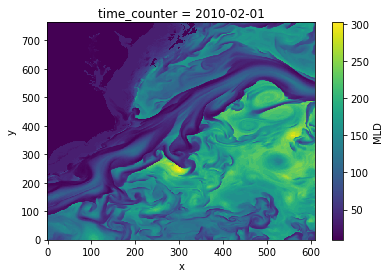

In [14]:
MLDw.isel(time_counter=0).plot()

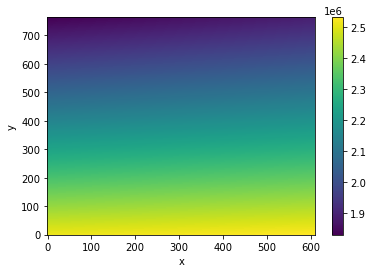

In [12]:
area = (enatl01w.e1t * enatl01w.e2t)

area.plot()

In [13]:
dxw = xr.DataArray(enatl01w.e1u.data, dims=['y','x'],
                   coords={'y':np.arange(len(enatl01w.y)),
                           'x':np.arange(len(enatl01w.x))}
                  ) # x-spacing centered at western cell edge

dyw = xr.DataArray(enatl01w.e2u.data, dims=['y','x'],
                   coords={'y':np.arange(len(enatl01w.y)),
                           'x':np.arange(len(enatl01w.x))}
                  ) # y-spacing centered at western cell edge

dxs = xr.DataArray(enatl01w.e1v.data, dims=['y','x'],
                   coords={'y':np.arange(len(enatl01w.y)),
                           'x':np.arange(len(enatl01w.x))}
                  ) # x-spacing centered at southern cell edge

dys = xr.DataArray(enatl01w.e2v.data, dims=['y','x'],
                   coords={'y':np.arange(len(enatl01w.y)),
                           'x':np.arange(len(enatl01w.x))}
                  ) # y-spacing centered at southern cell edge
dxw

<xarray.DataArray 'open_dataset-21513600a1da33079a279495ac482a6ae1u-55feb48f97fb0cd40bed8dce18f00a91' (y: 763, x: 611)>
dask.array<open_dataset-21513600a1da33079a279495ac482a6ae1u, shape=(763, 611), dtype=float64, chunksize=(73, 611), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 754 755 756 757 758 759 760 761 762
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 602 603 604 605 606 607 608 609 610

In [14]:
dx_min = min(enatl01w.e1u.min(['y','x']), enatl01w.e2u.min(['y','x']),
             enatl01w.e1v.min(['y','x']), enatl01w.e2v.min(['y','x'])
            )
dx_min = dx_min.values
dx_min

array(1289.18071484)

In [15]:
kappa_w = xr.zeros_like(wet_mask)
kappa_w[:,1:-1,1:-1] += 1.
kappa_s = xr.zeros_like(wet_mask)
kappa_s[:,1:-1,1:-1] += 1.

In [16]:
filter_50km = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    n_steps=36,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={
        'wet_mask': wet_mask.chunk({'y':-1,'x':-1}), 
        'dxw': dxw.chunk({'y':-1,'x':-1}), 'dyw': dyw.chunk({'y':-1,'x':-1}), 
        'dxs': dxs.chunk({'y':-1,'x':-1}), 'dys': dys.chunk({'y':-1,'x':-1}), 
        'area': area.chunk({'y':-1,'x':-1}), 
        'kappa_w': kappa_w.chunk({'y':-1,'x':-1}), 'kappa_s': kappa_s.chunk({'y':-1,'x':-1})
    }
)

filter_30km = gcm_filters.Filter(
    filter_scale=3e4,   # 30 km
    dx_min=dx_min,
#     n_steps=36,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={
        'wet_mask': wet_mask.chunk({'y':-1,'x':-1}), 
        'dxw': dxw.chunk({'y':-1,'x':-1}), 'dyw': dyw.chunk({'y':-1,'x':-1}), 
        'dxs': dxs.chunk({'y':-1,'x':-1}), 'dys': dys.chunk({'y':-1,'x':-1}), 
        'area': area.chunk({'y':-1,'x':-1}), 
        'kappa_w': kappa_w.chunk({'y':-1,'x':-1}), 'kappa_s': kappa_s.chunk({'y':-1,'x':-1})
    }
)
filter_30km

<string>:11: UserWarning: You have set n_steps below the default. Results might not be accurate.


Filter(filter_scale=30000.0, dx_min=array(1289.18071484), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=26, grid_type=<GridType.IRREGULAR_WITH_LAND: 5>)

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:4351: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


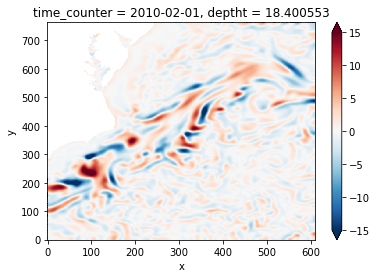

In [17]:
ww_filtered_to_30km = filter_30km.apply(ww.chunk({'y':-1,'x':-1}), dims=['y', 'x'])

(ww_filtered_to_30km.where(enatl01w.tmask!=0.).isel(time_counter=0,deptht=10)
 * 86400).plot(vmax=15,vmin=-15,cmap='RdBu_r')

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:4351: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:4351: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/tmp/ipykernel_996/1158580794.py:40: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs[0].pcolormesh(enatl01w.lon.isel(y=slice(1,-1),x=slice(1,-1)),
/tmp/ipykernel_996/1158580794.py:45: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'go

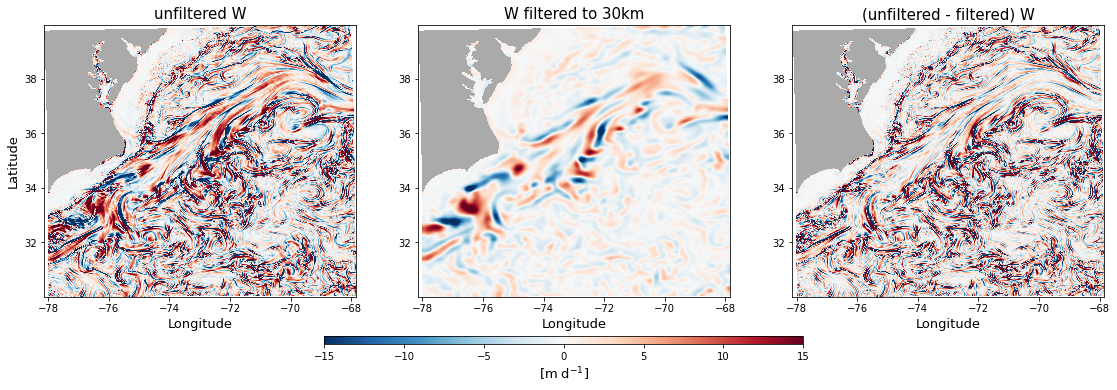

In [41]:
vmin = -15
vmax = 15

fig, axs = plt.subplots(1,3,figsize=(19,6))

im = axs[0].pcolormesh(enatl01w.lon.isel(y=slice(1,-1),x=slice(1,-1)), 
                  enatl01w.lat.isel(y=slice(1,-1),x=slice(1,-1)),
                  (ww.where(enatl01w.tmask!=0.)*86400).isel(time_counter=0, deptht=10,
                                          y=slice(1,-1),x=slice(1,-1)), 
                vmin=vmin, vmax=vmax, 
                cmap='RdBu_r', 
#                   cbar_kwargs={'label': r'm d$^{-1}$'},
                  shading='auto', rasterized=True
)
axs[0].set_title('unfiltered W', fontsize=15)

axs[1].pcolormesh(enatl01w.lon.isel(y=slice(1,-1),x=slice(1,-1)), 
                  enatl01w.lat.isel(y=slice(1,-1),x=slice(1,-1)),
                  (ww_filtered_to_30km.where(enatl01w.tmask!=0.).isel(time_counter=0,deptht=10,
                                                    y=slice(1,-1),x=slice(1,-1))*86400), 
                vmin=vmin, vmax=vmax, 
                cmap='RdBu_r', 
#                   cbar_kwargs={'label': r'm d$^{-1}$'}
                  shading='auto', rasterized=True
)
axs[1].set_title('W filtered to 30km', fontsize=15)

axs[2].pcolormesh(enatl01w.lon.isel(y=slice(1,-1),x=slice(1,-1)), 
                  enatl01w.lat.isel(y=slice(1,-1),x=slice(1,-1)),
                  ((ww.where(enatl01w.tmask!=0.).isel(time_counter=0,deptht=10) 
                    - ww_filtered_to_30km.where(enatl01w.tmask!=0.).isel(time_counter=0,deptht=10)
                   )*86400).isel(y=slice(1,-1),x=slice(1,-1)), 
                vmax=vmax, vmin=vmin,
                cmap='RdBu_r', 
#                   cbar_kwargs={'label': r'm d$^{-1}$'}
                  shading='auto', rasterized=True
)
axs[2].set_title(r'(unfiltered - filtered) W', fontsize=15);

axs[0].pcolormesh(enatl01w.lon.isel(y=slice(1,-1),x=slice(1,-1)), 
                  enatl01w.lat.isel(y=slice(1,-1),x=slice(1,-1)), 
                  np.ma.masked_values(enatl01w.tmask.isel(deptht=10,y=slice(1,-1),x=slice(1,-1)), 
                                      1.).astype(np.float64),
                  vmin=-1, vmax=2, cmap='binary', rasterized=True)
axs[1].pcolormesh(enatl01w.lon.isel(y=slice(1,-1),x=slice(1,-1)), 
                  enatl01w.lat.isel(y=slice(1,-1),x=slice(1,-1)), 
                  np.ma.masked_values(enatl01w.tmask.isel(deptht=10,y=slice(1,-1),x=slice(1,-1)), 
                                      1.).astype(np.float64),
                  vmin=-1, vmax=2, cmap='binary', rasterized=True)
axs[2].pcolormesh(enatl01w.lon.isel(y=slice(1,-1),x=slice(1,-1)), 
                  enatl01w.lat.isel(y=slice(1,-1),x=slice(1,-1)), 
                  np.ma.masked_values(enatl01w.tmask.isel(deptht=10,y=slice(1,-1),x=slice(1,-1)), 
                                      1.).astype(np.float64),
                  vmin=-1, vmax=2, cmap='binary', rasterized=True)

axs[0].set_ylabel(r"Latitude", fontsize=13)
axs[0].set_xlabel(r"Longitude", fontsize=13)
axs[1].set_xlabel(r"Longitude", fontsize=13)
axs[2].set_xlabel(r"Longitude", fontsize=13)

fig.subplots_adjust(bottom=0.25, hspace=.22)
cbaxes = fig.add_axes([0.33, 0.14, 0.35, 0.019]) 
cbar = fig.colorbar(im, orientation='horizontal', cax=cbaxes,
#                     ticks=[-2.8,-2.1,-1.4,-.7,0.,.7,1.4,2.1,2.8]
                   )
# cbar.set_powerlimits(-1,1)
cbar.set_label(r'[m d$^{-1}$]', fontsize=13)

plt.savefig('/home/jovyan/Figures/eNATL01-30km_wp_Feb-01.pdf')

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:4351: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


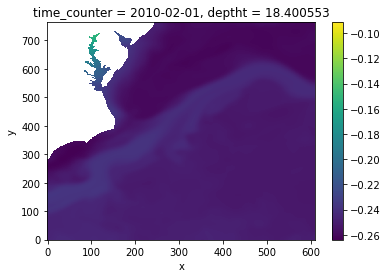

In [36]:
bw_filtered_to_30km = filter_30km.apply(bw.chunk({'y':-1,'x':-1}), dims=['y', 'x'])

(bw_filtered_to_30km.where(enatl01w.tmask!=0.).isel(time_counter=0,deptht=10)).plot()

/tmp/ipykernel_996/1230540105.py:36: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs[0].pcolormesh(enatl01w.lon.isel(y=slice(1,-1),x=slice(1,-1)),
/tmp/ipykernel_996/1230540105.py:41: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs[1].pcolormesh(enatl01w.lon.isel(y=slice(1,-1),x=slice(1,-1)),
/tmp/ipykernel_996/1230540105.py:46: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specif

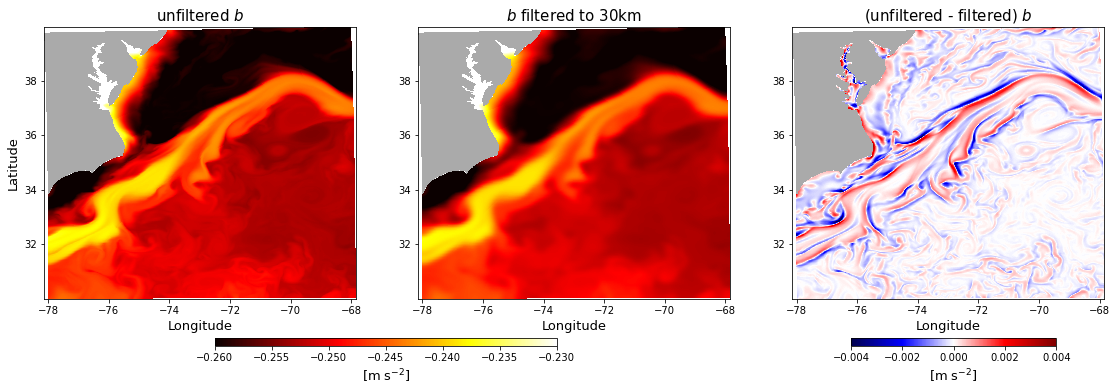

In [42]:
vmin = -.26
vmax = -.23

fig, axs = plt.subplots(1,3,figsize=(19,6))

im = axs[0].pcolormesh(enatl01w.lon.isel(y=slice(1,-1),x=slice(1,-1)), 
                       enatl01w.lat.isel(y=slice(1,-1),x=slice(1,-1)),
                       (bw).isel(time_counter=0,deptht=10,y=slice(1,-1),x=slice(1,-1)), 
                vmin=vmin, vmax=vmax, 
                cmap='hot', 
                       shading='auto', rasterized=True
)
axs[0].set_title(r'unfiltered $b$', fontsize=15)

axs[1].pcolormesh(enatl01w.lon.isel(y=slice(1,-1),x=slice(1,-1)), 
                  enatl01w.lat.isel(y=slice(1,-1),x=slice(1,-1)),
                  bw_filtered_to_30km.isel(time_counter=0,deptht=10,
                                           y=slice(1,-1),x=slice(1,-1)), 
                  vmin=vmin, vmax=vmax, 
                  cmap='hot', 
                  shading='auto', rasterized=True
)
axs[1].set_title(r'$b$ filtered to 30km', fontsize=15)

im2 = axs[2].pcolormesh(enatl01w.lon.isel(y=slice(1,-1),x=slice(1,-1)), 
                        enatl01w.lat.isel(y=slice(1,-1),x=slice(1,-1)),
                        (bw.isel(time_counter=0,deptht=10) 
                         - bw_filtered_to_30km.isel(time_counter=0,deptht=10)
                        ).isel(y=slice(1,-1),x=slice(1,-1)), 
                        vmax=.004, vmin=-.004,
                        cmap='seismic', 
                        shading='auto', rasterized=True
)
axs[2].set_title(r'(unfiltered - filtered) $b$', fontsize=15);

axs[0].pcolormesh(enatl01w.lon.isel(y=slice(1,-1),x=slice(1,-1)), 
                  enatl01w.lat.isel(y=slice(1,-1),x=slice(1,-1)), 
                  np.ma.masked_values(enatl01w.tmask.isel(deptht=10,y=slice(1,-1),x=slice(1,-1)), 
                                      1.).astype(np.float64),
                  vmin=-1, vmax=2, cmap='binary', rasterized=True)
axs[1].pcolormesh(enatl01w.lon.isel(y=slice(1,-1),x=slice(1,-1)), 
                  enatl01w.lat.isel(y=slice(1,-1),x=slice(1,-1)), 
                  np.ma.masked_values(enatl01w.tmask.isel(deptht=10,y=slice(1,-1),x=slice(1,-1)), 
                                      1.).astype(np.float64),
                  vmin=-1, vmax=2, cmap='binary', rasterized=True)
axs[2].pcolormesh(enatl01w.lon.isel(y=slice(1,-1),x=slice(1,-1)), 
                  enatl01w.lat.isel(y=slice(1,-1),x=slice(1,-1)), 
                  np.ma.masked_values(enatl01w.tmask.isel(deptht=10,y=slice(1,-1),x=slice(1,-1)), 
                                      1.).astype(np.float64),
                  vmin=-1, vmax=2, cmap='binary', rasterized=True)

axs[0].set_ylabel(r"Latitude", fontsize=13)
axs[0].set_xlabel(r"Longitude", fontsize=13)
axs[1].set_xlabel(r"Longitude", fontsize=13)
axs[2].set_xlabel(r"Longitude", fontsize=13)

fig.subplots_adjust(bottom=0.25, hspace=.22)
cbaxes = fig.add_axes([0.25, 0.14, 0.25, 0.019]) 
cbar = fig.colorbar(im, orientation='horizontal', cax=cbaxes,
#                     ticks=[-2.8,-2.1,-1.4,-.7,0.,.7,1.4,2.1,2.8]
                   )
# cbar.set_powerlimits(-1,1)
cbar.set_label(r'[m s$^{-2}$]', fontsize=13)
cbaxes = fig.add_axes([0.715, 0.14, 0.15, 0.019]) 
cbar = fig.colorbar(im2, orientation='horizontal', cax=cbaxes,
                    ticks=[-.004,-.002,0.,.002,.004]
                   )
# cbar.set_powerlimits(-1,1)
cbar.set_label(r'[m s$^{-2}$]', fontsize=13)

plt.savefig('/home/jovyan/Figures/eNATL01-30km_bp_Feb-01.pdf')

In [29]:
wpbpw = ((((ww - ww_filtered_to_30km
           ) * (bw - bw_filtered_to_30km
               )
          ).where(enatl01w.tmask!=0.) * enatl01w.e3t_0
         ).where(enatl01w.deptht.isel(deptht=slice(None,-1)) <= MLDw
                ).isel(y=slice(1,-1),x=slice(1,-1)).sum('deptht',skipna=True) 
         / MLDw.isel(y=slice(1,-1),x=slice(1,-1)))
wpbpw

,Array,Chunk
Bytes,314.69 MiB,273.75 kiB
Shape,"(89, 761, 609)","(3, 73, 160)"
Count,626317 Tasks,1680 Chunks
Type,float64,numpy.ndarray


In [30]:
tmp_path = f'{SCRATCH}/region01/eNATL60/'+f'wb-30km_z0-MLD_fma.zarr'
print(tmp_path)
store_tmp = gcs.get_mapper(tmp_path)
wpbpw.reset_coords(drop=True).chunk({'y':200,'x':160}).to_dataset(name='wpbp').to_zarr(store_tmp, mode='w')

gcs://meom-ige-scratch/roxyboy/region01/eNATL60/wb-30km_z0-MLD_fma.zarr


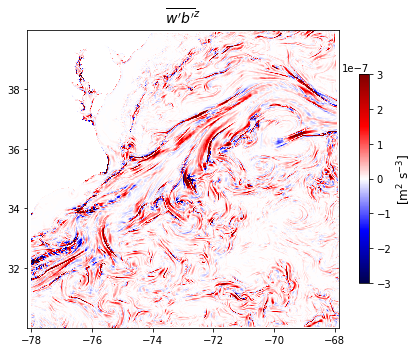

In [32]:
wpbpw = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/eNATL60/wb-30km_z0-MLD_fma.zarr")).wpbp

fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)
im = ax.pcolormesh(enatl01w.lon.isel(y=slice(1,-1),x=slice(1,-1)), 
                  enatl01w.lat.isel(y=slice(1,-1),x=slice(1,-1)),
                  wpbpw.isel(time_counter=0).where(enatl01w.tmask.isel(deptht=0,y=slice(1,-1),x=slice(1,-1))!=0.),
                  vmin=-3e-7, vmax=3e-7,
                  cmap='seismic', shading='auto', rasterized=True
)

ax.set_title(r"$\overline{w'b'}^z$", fontsize=14)
cbar = fig.colorbar(im, ax=ax, shrink=.7)
cbar.set_label(r"[m$^2$ s$^{-3}$]", fontsize=12)

plt.savefig('/home/jovyan/Figures/eNATL01_wpbpz-30km_Feb-01.pdf')

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:4351: PerformanceWarning: Increasing number of chunks by factor of 16
  result = blockwise(


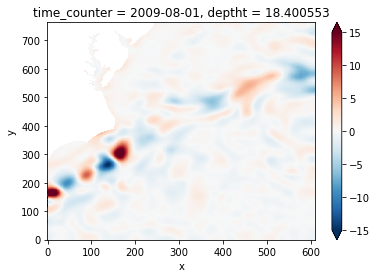

In [18]:
ws_filtered_to_50km = filter_50km.apply(ws.chunk({'y':-1,'x':-1}), dims=['y', 'x'])

(ws_filtered_to_50km.where(enatl01s.tmask!=0.).isel(time_counter=0,deptht=10)
 * 86400).plot(vmax=15,vmin=-15,cmap='RdBu_r')

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:4351: PerformanceWarning: Increasing number of chunks by factor of 16
  result = blockwise(


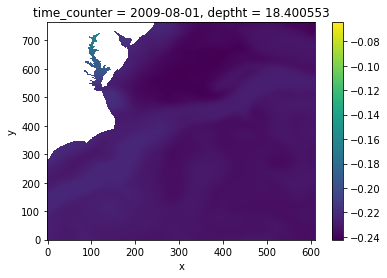

In [19]:
bs_filtered_to_50km = filter_50km.apply(bs.chunk({'y':-1,'x':-1}), dims=['y', 'x'])

(bs_filtered_to_50km.where(enatl01s.tmask!=0.).isel(time_counter=0,deptht=10)).plot()

In [20]:
wpbps = ((((ws - ws_filtered_to_50km
           ) * (bs - bs_filtered_to_50km
               )
          ).where(enatl01s.tmask!=0.) * enatl01s.e3t_0
         ).where(enatl01s.deptht.isel(deptht=slice(None,-1)) <= MLDs
                ).isel(y=slice(1,-1),x=slice(1,-1)).sum('deptht',skipna=True) 
         / MLDs.isel(y=slice(1,-1),x=slice(1,-1)))
wpbps

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


,Array,Chunk
Bytes,215.69 MiB,272.04 kiB
Shape,"(61, 761, 609)","(3, 73, 159)"
Count,521467 Tasks,2058 Chunks
Type,float64,numpy.ndarray


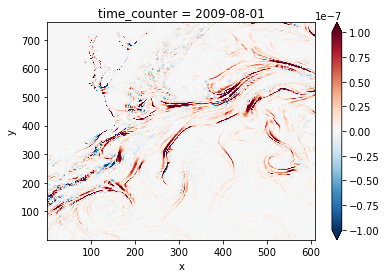

In [28]:
wpbps.isel(time_counter=0).plot(vmax=1e-7)

In [21]:
tmp_path = f'{SCRATCH}/region01/eNATL60/'+f'wb_z0-MLD_aso.zarr'
print(tmp_path)
store_tmp = gcs.get_mapper(tmp_path)
wpbps.reset_coords(drop=True).chunk({'y':200,'x':160}).to_dataset(name='wpbp').to_zarr(store_tmp, mode='w')

gcs://meom-ige-scratch/roxyboy/region01/eNATL60/wb_z0-MLD_aso.zarr
